# Эксперимент №1: расчет характеристик тандемной сети с узлами MAP/PH/1/N с помощью имитационного моделирования и машинного обучения

В этом эксперименте мы рассчитаем различные характеристики сетей с линейной топологией, на вход которых поступает MAP-поток, а обслуживание имеет распределение фазового типа. Сначала мы рассчитаем характеристики на заданной сетке статистических параметров с помощью имитационного моделирования сети, а затем используем полученные результаты для обучения нейросетевых и других моделей ML, которые сможем использовать для очень быстрой оценки характеристик сетей. Например, такой подход полезен при нахождении решений задач оптимизации топологии, когда характеристики сетей с линейной топологией являются ограничениями в алгоритме ветвей и границ. 

## Подготовка ноутбука

Импортируем все необходимые библиотеки, настроим флаги и константы, которыми будем пользоваться в эксперименте, и определим служебные функции, чтобы не отвлекаться на них в расчетной части эксперимента.

In [7]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [9]:
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import product
from collections import namedtuple
import time
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pyqumo.random import Distribution, Exponential, HyperExponential, Erlang
from pyqumo.cqumo.sim import simulate_tandem

# Поключаем пакеты для ML
import math
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

In [10]:
# Настраиваем matplotlib
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

Определим переменные окружения, которые будут использоваться в эксперименте.

In [11]:
# Нужно ли пересчитывать все, или можно использовать результаты из файлов
FORCE_SIMULATION = False
# SIM_FILE_NAME = '01_tandem_simulation.csv'
SIM_FILE_NAME = '02_tandem_simulation_various_net_sizes.csv'
SIM_FILE_DIR = 'data'
SIM_FILE_PATH = os.path.join(SIM_FILE_DIR, SIM_FILE_NAME)

# Зададим число пакетов, передачу которых по сети мы будем моделировать.
# Чем выше это число, тем точнее результаты, но на их получение нужно больше времени.
NUM_PACKETS = 100000

# Цветовая схема для графиков
CMAP_NAME = 'viridis'

In [12]:
def get_color(x):
    """
    Получить цвет из текущей карты.
    """
    return cm.get_cmap(CMAP_NAME)(x)

## Нахождение PH-распределений

PH-распределения для моделирования входящего потока и времени обслуживания будем находить по первым двум моментам по следующим правилам:

- если коэффициент вариации $c = \sigma / m_1 < 1$, то в качестве PH-распределения возьмем распределение Эрланга с самым близким значением $\tilde{\sigma}$;
- если коэффициент вариации $c > 1$, то в качестве PH-распределения возьмем гиперэкспоненциальное распределение;
- если коэффициент вариации $c = 1$, то распределение - экспоненциальное.

In [13]:
def fit_ph(avg: float, std: float) -> Distribution:
    """
    Возвращает PH-распределение по стандартному отклонению и среднему значению.
    """
    cv = std / avg
    if cv == 1:
        return Exponential(avg)
    if cv > 1:
        return HyperExponential.fit(avg, std)
    return Erlang.fit(avg, std)

## Вызов имитационной модели, чтение и сохранение результатов

Определим полезные функции, которые нам потребуются для работы с данными имитационного моделирования:

- `load_sim_data()`: читает файл `SIM_FILE_NAME`, если он существует, или создает новый `DataFrame` для хранения данных о результатах имитационного моделирования.
- `save_sim_data()`: сохраняет результаты, записанные в `DataFrame`, в файл `SIM_FILE_PATH`.

In [20]:
COLUMNS = (
    'ArrAvg', 
    'ArrStd', 
    'ArrCv', 
    'SrvAvg', 
    'SrvStd', 
    'SrvCv', 
    'Rho', 
    'NetSize', 
    'Capacity', 
    'NumPackets',
    'DelayAvg', 
    'DelayStd', 
    'DeliveryProb',
)


def save_sim_data(df: pd.DataFrame):
    """
    Сохранить в файл данные о результатах имитационного моделирования.
    """
    if not os.path.exists(SIM_FILE_DIR):
        os.makedirs(SIM_FILE_DIR)
    df.to_csv(SIM_FILE_PATH, index_label='Id')

    
def load_sim_data() -> pd.DataFrame:
    """
    Загрузить данные о резулдьтатах имитационного моделирования.
    """       
    if os.path.exists(SIM_FILE_PATH):
        return pd.read_csv(SIM_FILE_PATH, index_col='Id')
    return pd.DataFrame(columns=COLUMNS, index_col='Id')

sim_data = load_sim_data()
sim_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ArrAvg        0 non-null      object
 1   ArrStd        0 non-null      object
 2   ArrCv         0 non-null      object
 3   SrvAvg        0 non-null      object
 4   SrvStd        0 non-null      object
 5   SrvCv         0 non-null      object
 6   Rho           0 non-null      object
 7   NetSize       0 non-null      object
 8   Capacity      0 non-null      object
 9   NumPackets    0 non-null      object
 10  DelayAvg      0 non-null      object
 11  DelayStd      0 non-null      object
 12  DeliveryProb  0 non-null      object
dtypes: object(13)
memory usage: 0.0+ bytes


Функция `simulate(df, force=False, ...) -> pd.DataFrame` работает следующим образом:

- если в `df` нет строки, соответствующей переданным параметрам, то выполняется симуляция и функция возвращает новый `DataFrame`, содержащий результаты симуляции;
- если в `df` есть строка, соответствующая переданным параметрам, то симуляция выполняется, если выполнено любое из следующих условий:
    - передан аргумент `debug=True`
    - в настройках окружения (см. выше) установлен флаг `FORCE_SIMULATION=True`
    - если число пакетов, которые нужно промоделировать, больше числа пакетов, которое использовалось в предыдущей симуляции

Функция возвращает новый `DataFrame`, содержащий результаты заданной симуляции.

In [21]:
def simulate(
    df: pd.DataFrame, *, 
    arr_avg: float,
    arr_std: float,
    srv_avg: float,
    srv_std: float,
    net_size: int,
    capacity: int,
    num_packets: int,
    force: bool = False
) -> pd.DataFrame:
    """
    Выполнить симуляцию, если результатов нет в `df` или требуется их пересчитать, и вернуть новый `DataFrame`.
    """
    row_df = df[
        (df.ArrAvg == arr_avg) &
        (df.ArrStd == arr_std) &
        (df.SrvAvg == srv_avg) &
        (df.SrvStd == srv_std) &
        (df.NetSize == net_size) &
        (df.Capacity == capacity)]
    
    # Вычислим признаки, которые говорят о необходимости пересчета:
    no_row = len(row_df) == 0
    not_enough_packets = (not no_row) and (row_df.NumPackets.iloc[0] < num_packets)

    # Проверим, нужно ли пересчитать результаты:
    if force or no_row or not_enough_packets:
        arr = fit_ph(avg=arr_avg, std=arr_std)
        srv = fit_ph(avg=srv_avg, std=srv_std)
        ret = simulate_tandem(arr, [srv] * net_size, capacity, num_packets)

        row_data = {
            'ArrAvg': arr_avg,
            'ArrStd': arr_std,
            'ArrCv': arr_std / arr_avg,
            'SrvAvg': srv_avg,
            'SrvStd': srv_std,
            'SrvCv': srv_std / srv_avg,
            'Rho': arr_avg / srv_avg,
            'NetSize': net_size,
            'Capacity': capacity,
            'NumPackets': num_packets,
            'DelayAvg': ret.delivery_delays[0].avg,
            'DelayStd': ret.delivery_delays[0].std,
            'DeliveryProb': ret.delivery_prob[0],
        }

        # Если строки еще вообще не было, добавляем ее, а если была - обновляем:
        if no_row:
            df = df.append(row_data, ignore_index=True)
        else:
            df.update(pd.DataFrame(row_data, index=[row_df.index[0]]))

    return df

## Определяем сетку параметров модели

Будем считать, что сеть состоит из $L$ узлов, пакеты поступают на первую станцию и передаються по сети до тех пор, пока не будут обслужены последней станцией, либо не будут потерены из-за переполнения буфера на очередном узле.

Сеть будем описывать с помощью шести параметров:

- среднее значение интервалов между последовательными поступлениями пакетов в сеть ($\lambda^{-1}$)
- стандартное отклонение величин интервалов между последовательными поступлениями пакетов в сеть ($\sigma_A$)
- средняя длительность обслуживания ($\mu^{-1}$)
- стандартное отклонение длительности обслуживания ($\sigma_S$)
- число станций в сети ($L$)
- емкость очередей ($N$)

Из этих параметров можно полуить производные значения, которые оказываются более удобными при анализе:

- загрузка первой станции $\rho = \lambda / \mu$
- коэффициент вариации интервалов между поступлениями пакетов $c_A = \lambda \sigma_A$
- коэффициент вариации времени обслуживания $c_S = \mu \sigma_S$

Сетку будем задавать на множестве параметров $(\lambda^{-1}, \sigma_A, \mu^{-1}, \sigma_S, L, N)$.

Чтобы не пересчитывать результаты каждый раз заново, будем сохранять результаты расчета в файл `data/01_tandem_simulations.csv`. Если такого файла нет, или установлен флаг `FORCE_SIMULATION = True`, то каждая точка сетки будет рассчитана заново, а результаты расчета будут сохранены в файл. В противном случае расчет будет выполняться только в тогда, когда точки нет в файле, или в текущем расчете предполагается моделировать больше пакетов, то есть получить более точные результаты.

In [22]:
# ARRIVAL_AVG = [1, 3, 5, 7, 10, 13, 15, 17]
# ARRIVAL_STD = [1, 3, 5, 7, 10, 13, 15, 17]
# SERVICE_AVG = [2.5, 3. , 5. , 5.5, 7. , 8]
# SERVICE_STD = [1.,  2.5,  4, 5, 6, 7.5, 10]
# NET_SIZE = [5,  7,  9, 11, 15]
# CAPACITY = [6, 10, 12]

ARRIVAL_AVG = [8]
ARRIVAL_STD = [6]
SERVICE_AVG = [4]
SERVICE_STD = [2]
NET_SIZE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
CAPACITY = [8]


# Объединим все параметры в декартово произведение:
ALL_PARAMS = list(product(ARRIVAL_AVG, ARRIVAL_STD, SERVICE_AVG, SERVICE_STD, NET_SIZE, CAPACITY))

# Выполним симуляцию, если нужно:
for arr_avg, arr_std, srv_avg, srv_std, net_size, capacity in tqdm(ALL_PARAMS):
    sim_data = simulate(
        sim_data,
        arr_avg=arr_avg,
        arr_std=arr_std,
        srv_avg=srv_avg,
        srv_std=srv_std,
        net_size=net_size,
        capacity=capacity,
        num_packets=NUM_PACKETS,
        force=FORCE_SIMULATION
    )

print(sim_data.info())
print(sim_data)

# Сохраняем результат:
save_sim_data(sim_data)

  0%|          | 0/15 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ArrAvg        15 non-null     float64
 1   ArrStd        15 non-null     float64
 2   ArrCv         15 non-null     float64
 3   SrvAvg        15 non-null     float64
 4   SrvStd        15 non-null     float64
 5   SrvCv         15 non-null     float64
 6   Rho           15 non-null     float64
 7   NetSize       15 non-null     float64
 8   Capacity      15 non-null     float64
 9   NumPackets    15 non-null     float64
 10  DelayAvg      15 non-null     float64
 11  DelayStd      15 non-null     float64
 12  DeliveryProb  15 non-null     float64
dtypes: float64(13)
memory usage: 1.6 KB
None
    ArrAvg  ArrStd  ArrCv  SrvAvg  SrvStd  SrvCv  Rho  NetSize  Capacity  \
0      8.0     6.0   0.75     4.0     2.0    0.5  0.5      1.0       8.0   
1      8.0     6.0   0.75     4.0     2.0    0.5  0.5 

# ПОСТРОЕНИЕ ПРОГНОЗНОЙ МОДЕЛИ ВРЕМЕНИ МЕЖКОНЦЕВОЙ ЗАДЕРЖКИ МНОГОФАЗНОЙ СЕТИ МАСОВОГО ОБСЛУЖИВАНИЯ С ЛИНЕЙНОЙ ТОПОЛОГИЕЙ

На этапе моделирования мы получили данные симуляции, по которым планируем постороить регрессионные модели.

В качестве **предикторов** будем использовать следующие величины:

- **Arr.avg.** - среднее время между поступлениями пакетов;
- **Arr.std.** - стандартное отклонение времени между постулениями пакетов;
- **Srv.avg.** - среднее время обслуживания на пакетов фазах;
- **Srv.std.** - стандартное отклонение времени обслуживания на пакетов фазах;
- **Queue capacity** - размеры буфера очередей на фазах;
- **Num. stations** -  количество станций в многофазной сети;

На выходе имитационной модели сети рассчитывалось **среднее время межконцевой задержки**. Для этой величины мы будем строить прозоз

**Цель:** по полученным данным построить **прогнозную модель вермени межконцевой задержки** в тандеме

## ТАБЛИЦА ТРЕНИРОЧНЫХ ДАННЫХ
Мы получили данные симуляции для различных входных параметров. В общей сложности объем выборки составил 40440 строк. Данную выборку будем использовать для обучения будущих моделей.


In [135]:
simulation_data = pd.read_csv('data/01_tandem_simulation.csv')
COLUMNS = [
    'ArrAvg',
    'ArrStd',
    'SrvAvg',
    'SrvStd',
    'NetSize',
    'Capacity']


Для начала разобьем нашу исходную выборку на тренировочную и тестовую. Тестовая выборка будет нужна для оценки валидированных моделей.

In [41]:
train_data, test_data, y_train, y_test = train_test_split(
    simulation_data, simulation_data.loc[:, 'DelayAvg'], 
    test_size=0.33, 
    random_state=42)
x_train = train_data.loc[:, COLUMNS]
x_test = test_data.loc[:, COLUMNS]


### МЕТРИКИ
Для оценки полученных моделей нам будут необходимы метрики, а именно:

- Стандартное отклонение

In [42]:
def std(x: np.ndarray, y: np.ndarray)-> float:
    """
    Standard deviation between simulation model 
    values and estimates
    """
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

- Коэффициент корреляции

In [43]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    """
    Correlation coefficient between simulation model 
    values and estimate 
    """
    r = np.corrcoef(x, y)
    return r[0,1]

- и среднеквадратичная ошибка 

```sklearn.metrics.mean_squared_error ```.

## Приступим непосредственно к обучению

Начнем с ** Дерева решений **

In [44]:
tree = DecisionTreeRegressor(max_depth=36, splitter='best')
tree.fit(x_train, y_train)
tree_y = tree.predict(x_test)

In [45]:
# DataFrame для отриосвки графиков
draw_data = test_data.loc[:,COLUMNS]
draw_data['y_test'] = y_test 
draw_data['tree_y'] = tree_y

Показатели качества: коэффицент кореляции, среднеквадратичное отклонение и среднеквадратичное ошибка.

In [46]:
print(f'R = {corr(y_test, tree_y):.3f}')
print(f'STD = {std(y_test, tree_y):.3f}')
print(f'MSE = {mean_squared_error(y_test, tree_y):.3f}')


R = 0.947
STD = 37.185
MSE = 1382.604


На рисунке представлена **диаграмма рассеивания**

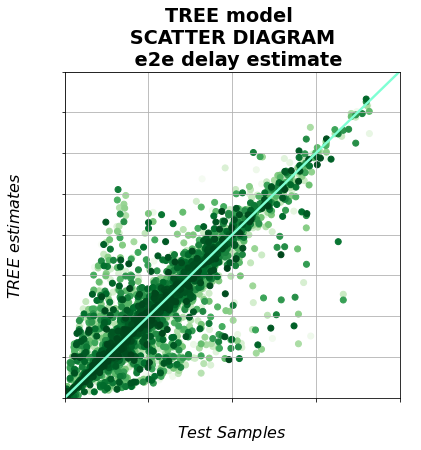

In [134]:
plt.subplots(figsize=(6, 6))
cm = plt.get_cmap('Greens')
col = [cm(float(i)/(len(y_test))) for i in range((len(y_test)))]
ax = plt.scatter(draw_data['tree_y'], draw_data['y_test'], c=col)
x = np.linspace(0,800,1000)
plt.plot(x, x, linestyle='-', linewidth=2.4, color='aquamarine')
plt.title('TREE model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

plt.xticks(color='w')
plt.yticks(color='w')

plt.xlim([0, 800])
plt.ylim([0, 800])

plt.xlabel(r'$Test \ Samples$')
plt.ylabel(r'$TREE \ estimates$')

plt.grid()

 Для различных длин тандема сетей представлены гистограммы оценок времени межконцевых задержек тестовой выборки.

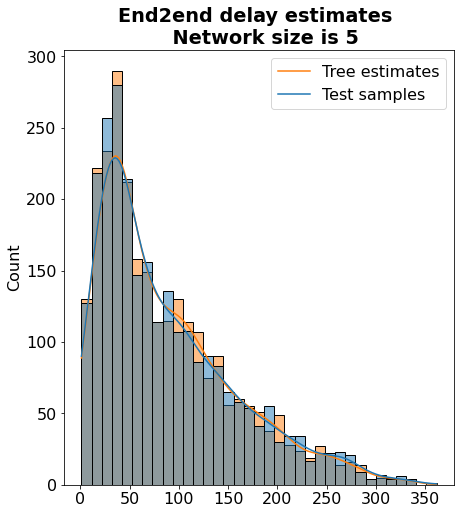

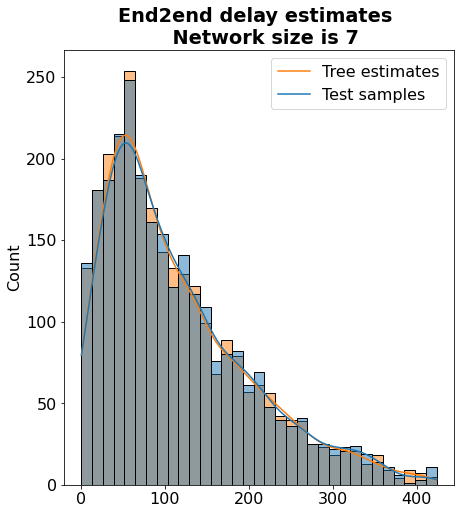

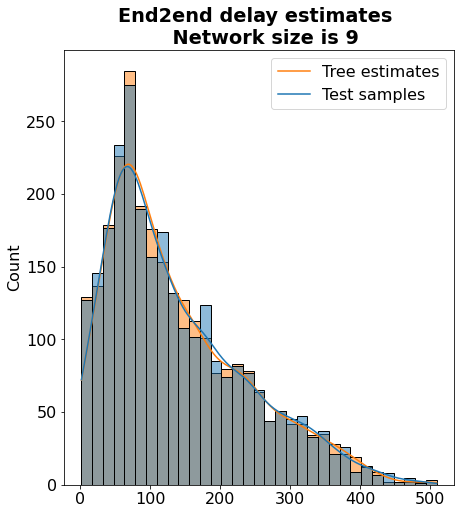

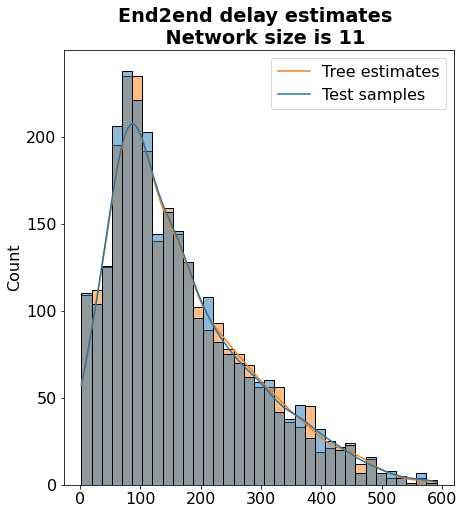

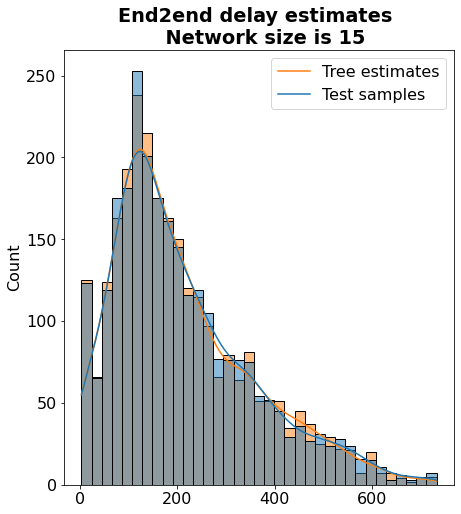

In [133]:
net_size = draw_data['NetSize'].unique()
net_size.sort()
for i in net_size:
    draw_hist = draw_data.loc[draw_data['NetSize']==i]
    plt.subplots(figsize=(7, 8))
    plt.title('End2end delay estimates \n  Network size is ' + str(int(i)), fontweight='bold')
    sns.histplot(draw_hist.loc[:,['tree_y','y_test']] , kde=True)
    plt.legend(['Tree estimates', 'Test samples'])

## Искусственные нейроные сети

In [49]:
def normalize(table, stat):
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose())/ stat.loc['std',:].transpose()

Необходимо провести нормализацию входных данных перед тем, как непосредственно приступить к обучению нейронной сети 

In [50]:
train_normalize = normalize(x_train, simulation_data.loc[:,COLUMNS].describe())
train_normalize.to_numpy();
test_normalize = normalize(x_test, simulation_data.loc[:,COLUMNS].describe())
test_normalize.to_numpy();

Построем модель будущей сети. Наша сеть состоит из одного скрытого слоя. Для обучения будем использовать алгоритм Адама.

In [51]:
def build_model(size):
    model = keras.Sequential([
        # Input Layer
        layers.Dense(36, activation='sigmoid', use_bias=True, input_shape=[size]),
        # Hidden Layer
        layers.Dense(36, activation='sigmoid', use_bias=True),
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mse'])
    return model

    
model = build_model(len(simulation_data.loc[:,COLUMNS].keys()))

In [52]:
%%time
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 1000
keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_normalize, y_train, epochs=EPOCHS, 
                    validation_split = 0.3, verbose=0, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                             patience=10)])

ann_y = model.predict(test_normalize).flatten()

CPU times: user 2min 7s, sys: 15.5 s, total: 2min 23s
Wall time: 1min 12s


Показатели качества: коэффицент кореляции, среднеквадратичное отклонение и среднеквадратичное ошибка.

In [53]:
print(f'R = {corr(y_test, ann_y):.3f}')
print(f'STD = {std(y_test, ann_y):.3f}')
print(f'MSE = {mean_squared_error(y_test, ann_y):.3f}')

R = 0.997
STD = 9.323
MSE = 86.912


На рисунке представлена диаграмма рассеивания полученной модели с помощью нейронной сети

In [54]:
# Добавим в draw_data оценку ann_y 
draw_data['ann_y'] = ann_y

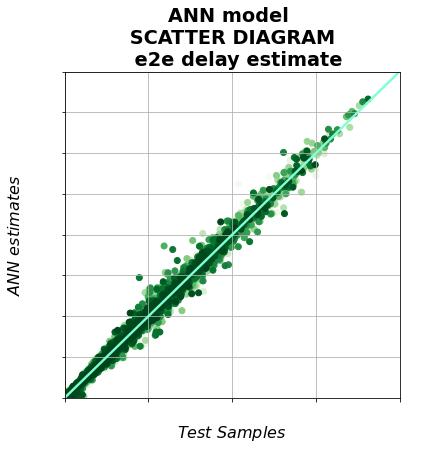

In [132]:
plt.subplots(figsize=(6, 6))
cm = plt.get_cmap('Greens')
col = [cm(float(i)/(len(ann_y))) for i in range((len(ann_y)))]
ax = plt.scatter(draw_data['ann_y'], draw_data['y_test'], c=col)
x = np.linspace(0,800,1000)
plt.plot(x, x, linestyle='-', linewidth=2.4, color='aquamarine')
plt.title('ANN model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

plt.xticks(color='w')
plt.yticks(color='w')

plt.xlim([0, 800])
plt.ylim([0, 800])

plt.xlabel(r'$Test \ Samples$')
plt.ylabel(r'$ANN \ estimates$')

plt.grid()


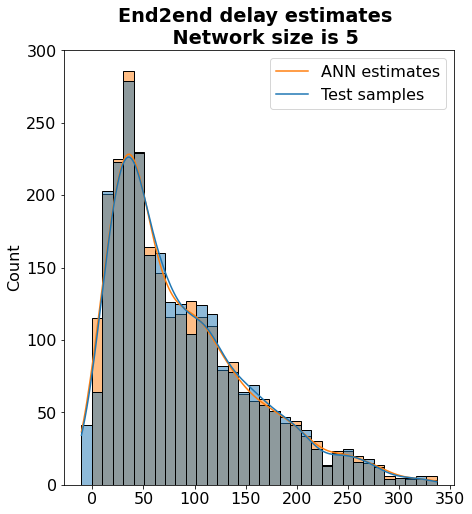

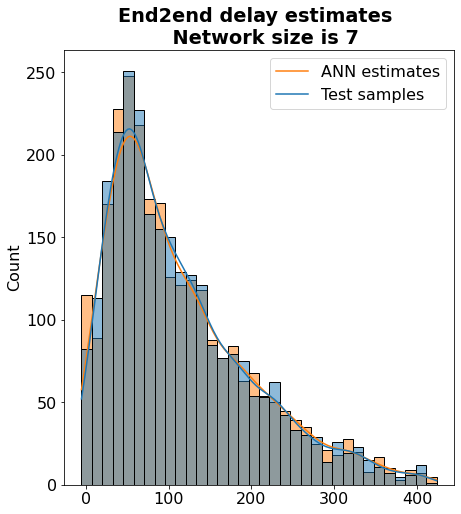

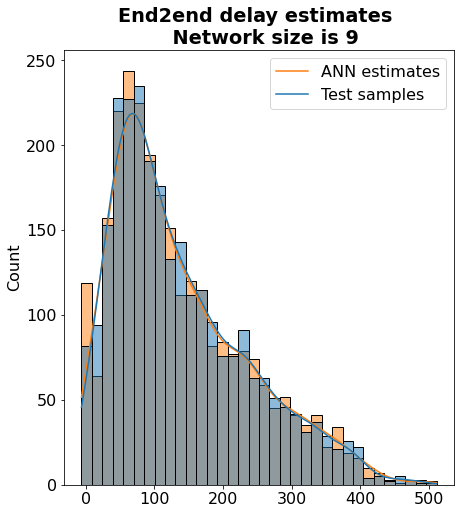

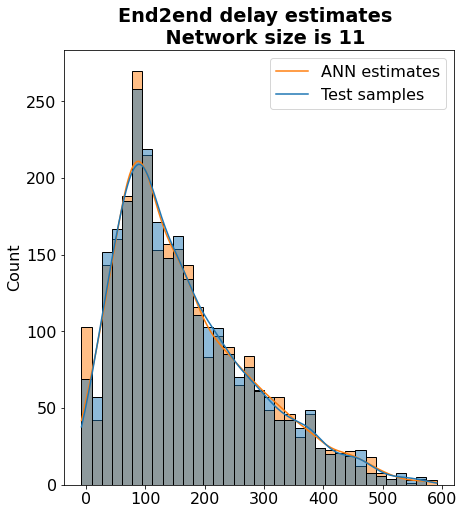

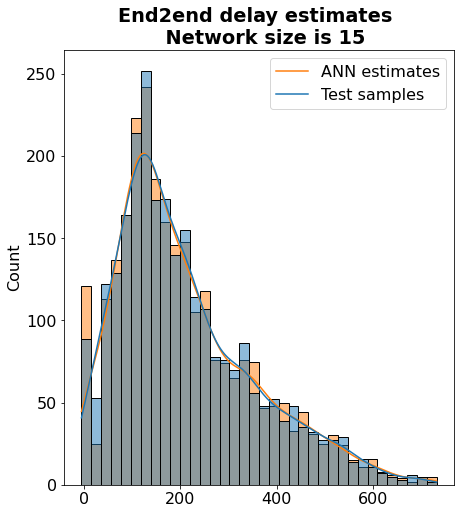

In [131]:


net_size = draw_data['NetSize'].unique()
net_size.sort()
for i in net_size:
    draw_hist = draw_data.loc[draw_data['NetSize']==i]
    plt.subplots(figsize=(7, 8))
    plt.title('End2end delay estimates \n  Network size is ' + str(int(i)), fontweight='bold')
    sns.histplot(draw_hist.loc[:,['ann_y','y_test']] , kde=True)
    plt.legend(['ANN estimates', 'Test samples'])

In [129]:

sns.pairplot(draw_data, hue='NetSize');

## Проверка адекватности моеделей для различных длин тандема.

Попробуем оценить точность моделей МО для оценки межконцевой задержки сети при различных размерах сети. Зафиксируем размер буфера, 1ый и 2ой момент для интервалов поступления пакетов и времени обслуживания. 

``` ARRIVAL_AVG = [8]
ARRIVAL_STD = [6]
SERVICE_AVG = [4]
SERVICE_STD = [2]
NET_SIZE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
CAPACITY = [8]
```

Данные имитационноые модели:

In [126]:
simulation_data_various_net_sizes = pd.read_csv('data/02_tandem_simulation_various_net_sizes.csv')

Сделаем прогноз для тестовой выборки. 

In [87]:
x_test_net_size = simulation_data_various_net_sizes.loc[:, COLUMNS]
y_test_net_size = simulation_data_various_net_sizes.loc[:, 'DelayAvg']

test_normalize_net_size = normalize(x_test_net_size, simulation_data.loc[:,COLUMNS].describe())
test_normalize_net_size.to_numpy();

ann_y_net_size = model.predict(test_normalize_net_size).flatten()
tree_y_net_size = tree.predict(x_test_net_size)

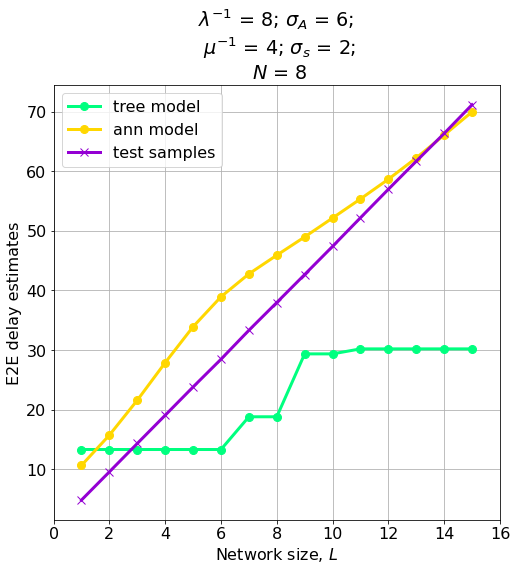

In [128]:
plt.subplots(figsize=(8, 8))
plt.title('$\lambda^{-1}$ = 8; $\sigma_A$ = 6; \n $\mu^{-1}$ = 4; $\sigma_s$ = 2; \n $N$ = 8')

plt.plot(x_test_net_size['NetSize'], tree_y_net_size,  '-og', label='tree model', color='springgreen', linewidth=3, markersize=8)
plt.plot(x_test_net_size['NetSize'], ann_y_net_size, '-or', label='ann model', color='gold', linewidth=3, markersize=8)
plt.plot(x_test_net_size['NetSize'], y_test_net_size, '-xb', label='test samples', color='darkviolet', linewidth=3, markersize=8)
plt.ylabel('E2E delay estimates')
plt.xlabel('Network size, $L$')
plt.xlim([0, 16])
plt.legend()
plt.grid()

**Показатели качества** для модели искусственной нейронной сети

In [105]:
print(f'R = {corr(y_test_net_size, ann_y_net_size):.3f}')
print(f'STD = {std(y_test_net_size, ann_y_net_size):.3f}')
print(f'MSE = {mean_squared_error(y_test_net_size, ann_y_net_size):.3f}')

R = 0.991
STD = 6.778
MSE = 42.881


**Показатели качества** для модели дерева решений

In [107]:
print(f'R = {corr(y_test_net_size, tree_y_net_size):.3f}')
print(f'STD = {std(y_test_net_size, tree_y_net_size):.3f}')
print(f'MSE = {mean_squared_error(y_test_net_size, tree_y_net_size):.3f}')

R = 0.917
STD = 21.898
MSE = 447.548
